In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable

/home/claire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """


In [4]:
g = 9.8 # gravity, m s^-2
l = 2000e3 # mantle depth, m
beta = 1/4
D = 0.67 # prefactor
kappa = 1e-6 # thermal diffusivity m^2 s^-1
C_p = 1200 # specific heat capacity
alpha = 2e-5 # thermal expansivity
k = 3 # W m^-1 K^-1
rho = 3000 # kg m^-3
nu = 2e17 # kinematic viscosity, m^s s^-1
T_s = 273 # surface temperature, K
T_0 = 1800 # initial mantle temperature, K

Gyr2s = 31557600*1e9 # time conversion

tf = 10.0 Gyr
E0 0.30719565329288456


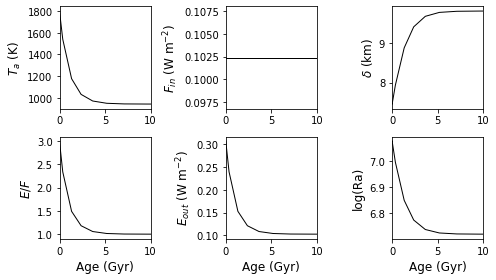

In [5]:
def Ra(T_a):
    return g*alpha*T_a*l**3/(kappa*nu)

def lid_thickness(T_a, E):
    return k*T_a/(2*E)
    
def F_in(T_a, t=None, F0=None):
    """Heat flux per unit area through bottom of convecting layer"""
    if F0 is None:
        return k*(g*alpha/(kappa*nu))**(beta/(1 - beta)) * l**(4*beta/(1 - beta)) * (D*T_a)**(1/(1 - beta))
    else:
        return F0
    

def E_out(T_a):
    """Heat flux per unit area out of top of convecting layer"""
    return k*(g*alpha/(kappa*nu))**(1/3) * (D*T_a)**(4/3)

def H_in():
    """Internal heat generation per unit volume in convecting layer"""
    return 0

def dTdt(t, T_avg, F0=None):
    deltaT = T_avg - T_s
    F = F_in(deltaT, t, F0)
    E = E_out(deltaT)
    H = H_in()
    #print('t =',t/Gyr2s, 'Gyr, T_avg =', T_avg, 'K, F =',F,'W m^-2, E =', E, 'W m^-2') 
    #print('E/F', E/F)
    return ((F - E) + H*l)/(rho*C_p*l)

def evolve(tf=None, t0=0):
    print('tf =',tf/Gyr2s, 'Gyr')
    E0 = E_out(T_0-T_s)
    print('E0', E0)
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, F0=E0/3), t_span=(t0,tf), y0=[T_0], method='RK45')

    F = [F_in(f.y[0]-T_s, t=f.t, F0=E_out(T_0-T_s)/3)]*len(f.t)
    E = E_out(np.array(f.y[0])-T_s)

    
    fig, axes = plt.subplots(2, 3, figsize=[7, 4])
    plot_one(axes[0][0], f.t/Gyr2s, 
         f.y[0], 
         '', '$T_{a}$ (K)')
    plot_one(axes[1][0], f.t/Gyr2s, 
         E/F, 
         'Age (Gyr)', '$E/F$', xticks=True)
    plot_one(axes[0][1], f.t/Gyr2s, 
         F, 
         '', '$F_{in}$ (W m$^{-2}$)')
    plot_one(axes[1][1], f.t/Gyr2s, 
         E, 
         'Age (Gyr)', '$E_{out}$ (W m$^{-2}$)', xticks=True)
    plot_one(axes[0][2], f.t/Gyr2s, 
         lid_thickness(f.y[0]-T_s, E)*1e-3,
         '', '$\delta$ (km)')
    plot_one(axes[1][2], f.t/Gyr2s, 
         np.log10(Ra(f.y[0]-T_s)),
         'Age (Gyr)', 'log(Ra)', xticks=True)
    plt.tight_layout()
    return None

def plot_one(ax, x, y, xlabel, ylabel, labelsize=12, legsize=14, lw=1, ls='-', marker=None, 
             ms=5,c='k', text=None, xticks=True, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

evolve(tf=10*Gyr2s)
